In [2]:
!pip install torch

     |████████████████████████████████| 831.4 MB 23 kB/s  eta 0:00:01     |████████████████▌               | 427.6 MB 1.9 MB/s eta 0:03:32


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

        Power  Hour  Days  Month  Temperature  humiduity  Wind_speed
0     239.935   9.0    14      7        16.30       82.0        21.6
1     249.107   9.5    14      7        15.50       88.5        21.6
2     233.270  10.0    14      7        14.70       95.0        21.6
3     240.485  10.5    14      7        14.25       95.5        21.6
4     280.533  11.0    14      7        13.80       96.0        14.4
...       ...   ...   ...    ...          ...        ...         ...
8171  394.590  14.5    30     12         7.90       99.0        10.8
8172  349.627  15.0    30     12         7.80       99.0        10.8
8173  377.815  15.5    30     12         7.65       99.5        10.8
8174  429.012  16.0    30     12         7.50      100.0        10.8
8175  487.536  16.5    30     12         7.55       99.5        10.8

[8176 rows x 7 columns]


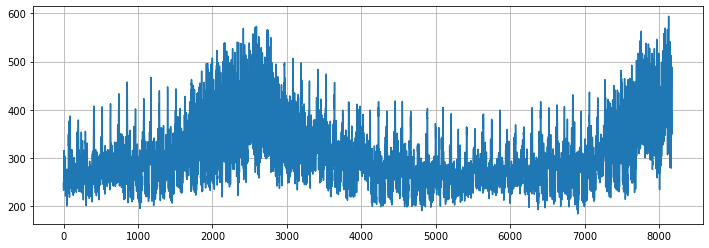

In [53]:
df = pd.read_csv('CER_Residents_worktime.csv', index_col=0, parse_dates=True)
df = df.reset_index(drop=True)
df = df.loc[:,['Power', 'Hour', 'Days', 'Month', 'Temperature', 'humiduity', 'Wind_speed']]
print(df)
plt.figure(figsize=(12, 4))
plt.grid(True)
plt.plot(df['Power'])

In [54]:
from sklearn.preprocessing import MinMaxScaler

train_size = 451 * 16 -1 # 8176/16 - 30 - 30, index from 0
validation_size = 30 * 16
# split the train set, validation set, test set
train_set = df[:train_size+1]
test_set = df[train_size+1:]
# normalizaiton to [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
train_norm = scaler.fit_transform(train_set)
train_norm

array([[-0.71292316, -1.        , -0.13333333, ...,  0.55183946,
         0.40983607, -0.44444444],
       [-0.66573809, -0.86666667, -0.13333333, ...,  0.49832776,
         0.62295082, -0.44444444],
       [-0.74721105, -0.73333333, -0.13333333, ...,  0.44481605,
         0.83606557, -0.44444444],
       ...,
       [-0.5267551 ,  0.73333333,  0.73333333, ...,  0.23411371,
         0.49180328, -0.33333333],
       [-0.35790846,  0.86666667,  0.73333333, ...,  0.18394649,
         0.73770492, -0.33333333],
       [-0.1494597 ,  1.        ,  0.73333333, ...,  0.18060201,
         0.68852459, -0.33333333]])

In [55]:
import torch
# tansform the train set to tensor
train_norm = torch.FloatTensor(train_norm)

# difine the time window
window_size = 12

# select 12 train sample to predict the 13th sample
def input_data(seq, ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window, label))
    return out

train_data = input_data(train_norm, window_size) # len(train)-len(test)-len(window)
print(len(train_data))
train_data[0]

7204


(tensor([[-0.7129, -1.0000, -0.1333,  0.0909,  0.5518,  0.4098, -0.4444],
         [-0.6657, -0.8667, -0.1333,  0.0909,  0.4983,  0.6230, -0.4444],
         [-0.7472, -0.7333, -0.1333,  0.0909,  0.4448,  0.8361, -0.4444],
         [-0.7101, -0.6000, -0.1333,  0.0909,  0.4147,  0.8525, -0.4444],
         [-0.5041, -0.4667, -0.1333,  0.0909,  0.3846,  0.8689, -0.6667],
         [-0.6184, -0.3333, -0.1333,  0.0909,  0.4181,  0.8689, -0.6667],
         [-0.5110, -0.2000, -0.1333,  0.0909,  0.4515,  0.8689, -0.5556],
         [-0.3239, -0.0667, -0.1333,  0.0909,  0.4749,  0.7377, -0.5556],
         [-0.4416,  0.0667, -0.1333,  0.0909,  0.4983,  0.6066, -0.2222],
         [-0.5936,  0.2000, -0.1333,  0.0909,  0.4783,  0.7377, -0.2222],
         [-0.7333,  0.3333, -0.1333,  0.0909,  0.4582,  0.8689, -0.4444],
         [-0.6676,  0.4667, -0.1333,  0.0909,  0.4415,  0.8852, -0.4444]]),
 tensor([[-0.6792,  0.6000, -0.1333,  0.0909,  0.4247,  0.9016, -0.6667]]))

In [56]:
import torch.nn as nn
# define the network structure
class LSTMnetwork(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size)
        
        # define fully-connected layer
        self.linear = nn.Linear(hidden_size, output_size)
        
        # initilization
        self.hidden = (torch.zeros(1, 1, self.hidden_size),
                       torch.zeros(1, 1, self.hidden_size))
    
    # define forward
    def forward(self, seq):
        lstm_out, self.hiddent = self.lstm(seq.view(len(seq), 1, -1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq), -1))
        return pred[0]

In [57]:
# define the loss function and optimizer
torch.manual_seed(42)
model = LSTMnetwork()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# check the parameters of network
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'________\n{sum(params):>6}')

count_parameters(model)

   400
 40000
   400
   400
   100
     1
________
 41301


In [59]:
import time

# train the model
epochs = 100
start_time = time.time()
for epoch in range(epochs):
    for seq, y_train in train_data:
        # initilization of gradient
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1, model.hidden_size),
                       torch.zeros(1, 1, model.hidden_size))
    
        y_pred = model(seq[0])
    
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1:2} Loss:{loss.item():10.8f}')
print(f'\nDuration:{time.time()-start_time:.0f} seconds')

/home/qcraft/Documents/Fan/miniconda3/envs/py37/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 7])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 Loss:0.27417859
Epoch: 2 Loss:0.30955973
Epoch: 3 Loss:0.31518468
Epoch: 4 Loss:0.31428078
Epoch: 5 Loss:0.31087276
Epoch: 6 Loss:0.31016269
Epoch: 7 Loss:0.30747086
Epoch: 8 Loss:0.30628052
Epoch: 9 Loss:0.30444592
Epoch:10 Loss:0.30289808
Epoch:11 Loss:0.30224040
Epoch:12 Loss:0.30255583
Epoch:13 Loss:0.30274537
Epoch:14 Loss:0.30296430
Epoch:15 Loss:0.30304512
Epoch:16 Loss:0.30327302
Epoch:17 Loss:0.30341437
Epoch:18 Loss:0.30325255
Epoch:19 Loss:0.30293611
Epoch:20 Loss:0.30270123
Epoch:21 Loss:0.30234668
Epoch:22 Loss:0.30231014
Epoch:23 Loss:0.30213282
Epoch:24 Loss:0.30199948
Epoch:25 Loss:0.30180150
Epoch:26 Loss:0.30175063
Epoch:27 Loss:0.30187199
Epoch:28 Loss:0.30181751
Epoch:29 Loss:0.30190784
Epoch:30 Loss:0.30230379
Epoch:31 Loss:0.30304766
Epoch:32 Loss:0.30369487
Epoch:33 Loss:0.30263329
Epoch:34 Loss:0.30333525
Epoch:35 Loss:0.30361897
Epoch:36 Loss:0.30421180
Epoch:37 Loss:0.30451226
Epoch:38 Loss:0.30480677
Epoch:39 Loss:0.30482489
Epoch:40 Loss:0.30489895
